# **1. Alien vs Predator 데이터셋**

In [2]:
from google.colab import files
files.upload()  # kaggle.json 업로드 창 표시
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [3]:
!kaggle datasets download -d pmigdal/alien-vs-predator-images

Dataset URL: https://www.kaggle.com/datasets/pmigdal/alien-vs-predator-images
License(s): ODbL-1.0
  0% 0.00/14.1M [00:00<?, ?B/s]
100% 14.1M/14.1M [00:00<00:00, 915MB/s]


In [4]:
!unzip -q alien-vs-predator-images.zip

# **2. Alexnet 모델을 활용한 Alien vs Predator 분류**

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [9]:
# 전처리

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),  # 모든 이미지를 224x224 크기로 고정
        transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),  # Affine 변환 (회전은 없음, 기울기(shear), 크기(scale)만 랜덤 변형)
        transforms.RandomHorizontalFlip(),  # 좌우반전을 랜덤으로 적용
        transforms.ToTensor()  # PIL 이미지를 PyTorch 텐서로 변환 (값 범위: 0~1)
    ]),
    'validation': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
}

# 훈련 데이터에는 데이터 증강(Data Augmentation) 을 적용하여 모델이 다양한 상황에 잘 일반화되도록 도와준다.
# 검증 데이터에는 오직 크기 조정(Resize) 과 Tensor 변환만 적용하여 예측 성능만 평가한다.

In [11]:
def target_transforms(target):
    return torch.FloatTensor([target])

- target : 정답값(label)
- [target] : 정답을 리스트 형태로 감싸기 -> [0] 또는 [1]
- torch.FloatTensor(...) : 해당 리스트를 FloatTensor로 변환 -> tensor([0.]) 또는 tensor([1.])


✅ 왜 이렇게 쓰나요?

일반적으로 ImageFolder 같은 데이터셋에서 label은 int (예: 0, 1) 형식입니다.

하지만 회귀 문제, 혹은 BCELoss (Binary Cross Entropy Loss) 같은 경우, label이 float 텐서 형식이기를 기대합니다.

예: BCELoss는 target이 FloatTensor이고 값이 [0.] 또는 [1.] 형태이길 원합니다.

In [12]:
# 이미지 분류용 데이터셋 생성

image_datasets = {
    'train': datasets.ImageFolder('data/train', data_transforms['train'],
                                  target_transform = target_transforms),
    'validation': datasets.ImageFolder('data/validation', data_transforms['validation'],
                                       target_transform=target_transforms)
}

- transform(입력 전처리), target_transform(정답값 전처리) 적용
- datasets.ImageFolder(): 디렉터리 구조에 따라 이미지와 레이블을 자동으로 불러오는 클래스
    - glass = 클래스0
    - noglass = 클래스1
- transform=data_transforms['train'] : 입력 이미지에 적용할 전처리 함수
- target_transform=target_transforms : 정답(label)에 적용할 전처리 함수

⋇ target_transforms : 정답(label)을 tensor([0.]) 또는 tensor([1.]) 형태의 FloatTensor로 변환

In [14]:
dataloaders = {
    'train': DataLoader(
        image_datasets['train'],
        batch_size = 32,
        shuffle=True
    ),
    'validation': DataLoader(
        image_datasets['validation'],
        batch_size=32,
        shuffle=False
    )
}

len(image_datasets['train']), len(image_datasets['validation'])

(694, 200)

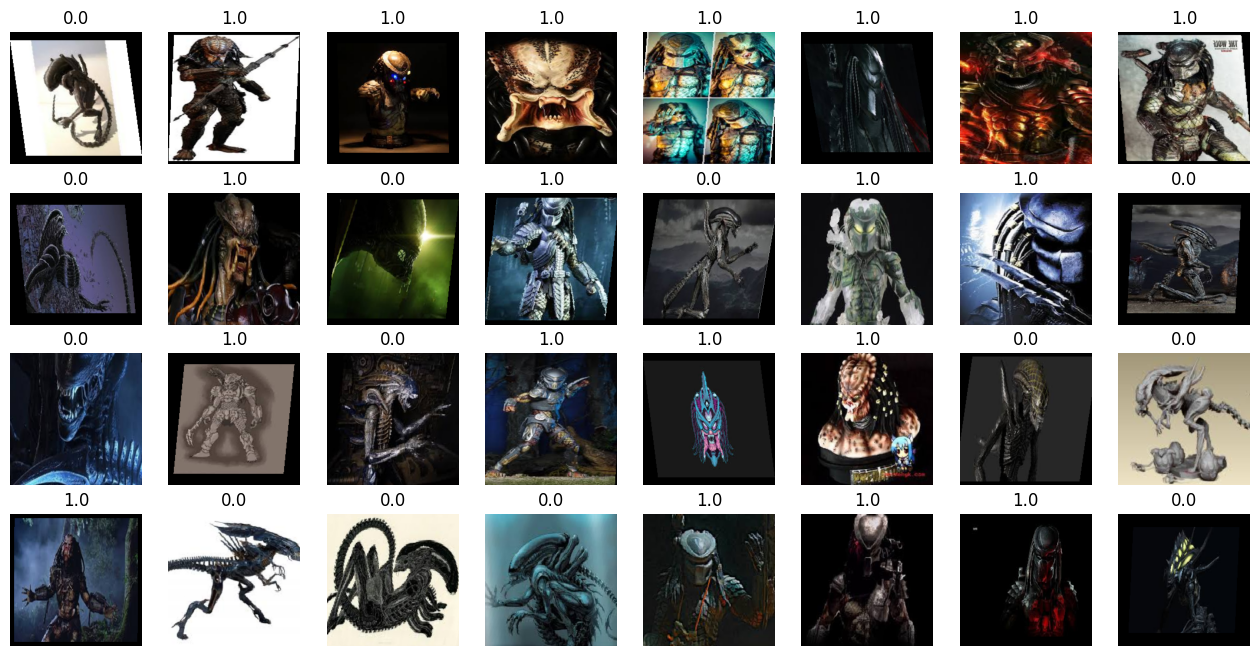

In [15]:
# 배치에서 첫 번째 묶음 꺼내기
imgs, labels = next(iter(dataloaders['train']))

fig, axes = plt.subplots(4, 8, figsize=(16, 8))

for ax, img, label in zip(axes.flatten(), imgs, labels):
    ax.imshow(img.permute(1, 2, 0)) # (3, 224, 224) -> (224, 224, 3)
    ax.set_title(label.item())
    ax.axis('off')

- dataloaders['train']: 학습용 DataLoader 객체 (batch 단위로 이미지 + 라벨 제공)
- iter(...) : 이터레이터로 변환
- next(...) : 첫 번째 배치를 꺼냄(한 번만 가져옴)
- imgs : 이미지 텐서(batch_size, C, H, W)


# **3. 전이학습**
전이 학습(Transfer Learning)은 이미 학습된 모델(주로 대규모 데이터셋에서 사전 학습된 딥러닝 모델)을 새로운 문제에 적용하여 학습 시간을 단축하고 성능을 향상시키는 방법입니다. 기존 모델이 학습한 특징(Feature)을 활용해, 새로운 데이터셋에서 모델의 일부(주로 마지막 레이어)만 다시 학습하거나 추가 학습(Fine-tuning)을 진행합니다. 이는 특히 데이터가 적거나 학습 리소스가 제한된 상황에서 효과적이며, 이미지 분류(예: ResNet, VGG), 자연어 처리(예: BERT, GPT) 등 다양한 분야에서 널리 사용됩니다.   (이미 학습된 가중치를 다른 곳에서 사용하는 것)

In [16]:
model = models.alexnet(weights='IMAGENET1K_V1').to(device)
print(model)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 149MB/s]


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

- models.alexnet(): AlexNet 구조 생성
- weights='IMAGENET1K_V1': 사전 학습된 ImageNet 가중치 사용
- .to(device) : 모델을 CPU 또는 GPU로 이동
- 용도: 전이학습 또는 feature extraction

※ 이미지넷

이미지넷(ImageNet)은 대규모 이미지 데이터셋으로, 컴퓨터 비전 연구와 딥러닝 모델 학습에 널리 사용됩니다. 2009년 스탠포드 대학의 페이페이 리(Fei-Fei Li) 교수팀이 구축했으며, 약 1,400만 장의 이미지와 22,000개 이상의 카테고리로 구성되어 있습니다. 이 중, 가장 널리 사용되는 ILSVRC(Imagenet Large Scale Visual Recognition Challenge) 버전은 약 1,000개의 클래스와 120만 장의 이미지를 포함합니다. 이미지넷은 모델이 객체를 분류하고 특징을 학습하는 데 필요한 풍부한 데이터와 레이블을 제공하며, ResNet, VGG, Inception 등 여러 혁신적인 모델이 이미지넷 대회를 통해 개발되었습니다. 이 데이터셋은 특히 사전 학습(Transfer Learning)에서 중요한 역할을 하며, 딥러닝 연구의 표준 벤치마크로 자리 잡았습니다.

In [17]:
for param in model.parameters():
    param.requires_grad = False   # 가져온 파라미터를 업데이트 하지 않음.(고정, freeze시킴.)

※ Model Freezing

Model Freezing은 전이 학습(Transfer Learning)에서 사전 학습된 모델의 일부 또는 전체 계층의 가중치를 고정하여 학습되지 않도록 설정하는 기법입니다. 주로 사전 학습된 모델의 초기 계층(Convolutional Layers 등)은 일반적인 특징(예: 가장자리, 패턴)을 학습했으므로 고정하고, 새로운 데이터셋에 특화된 특징을 학습하기 위해 최상위 계층(분류 헤드 등)만 학습합니다. 이 방법은 학습할 가중치의 수를 줄여 **계산 비용을 절감하고, 과적합을 방지하며, 데이터가 부족한 상황에서 특히 유용**합니다. 필요에 따라, 초기 학습이 끝난 후 일부 계층을 고정 해제(Fine-Tuning)하여 모델을 더 정교하게 조정할 수도 있습니다.

In [18]:
# 이진 분류(glass vs no glass) 용 분류기 구조 설정 (전이 학습용)

model.classifier = nn.Sequential(
    nn.Linear(256 * 6 * 6, 128),
    nn.ReLU(),
    nn.Linear(128, 1),
    nn.Sigmoid()
)
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_featur

- nn.Linear(256 * 6 * 6, 128)
    - 입력: AlexNet의 마지막 convolution layer 출력 크기 (256 x 6 x 6)

    - 출력: 128차원으로 압축된 벡터

💡 AlexNet의 feature extractor는 고정된 입력(224x224) 기준으로 항상 (256, 6, 6) 크기의 텐서를 출력합니다.

- nn.ReLU() 활성화 함수: 비선형성 추가

- nn.Linear(128, 1)
    - 출력층: 단 하나의 스칼라 값
    - 이 값은 "1일 확률" 또는 "positive class일 확률" 을 의미

- nn.Sigmoid()
    - 출력값을 0~1 사이의 확률 값으로 변환


```
Input (batch x 3 x 224 x 224)
   ↓
AlexNet feature extractor (conv layers)
   ↓
Flatten → (batch x 256*6*6)
   ↓
Linear(9216 → 128)
   ↓
ReLU
   ↓
Linear(128 → 1)
   ↓
Sigmoid → 확률값 출력 (예: 0.87 → "glass")
```

In [19]:
# 학습

# 옵티마이저 설정
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)


# 학습 반복
epochs = 10

for epoch in range(epochs):

    # train과 validation 반복 처리
    for phase in ['train', 'validation']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        sum_losses = 0
        sum_accs = 0

        # 배치 처리 : DataLoader를 통해 미니배치 단위로 데이터를 불러온다.
        for x_batch, y_batch in dataloaders[phase]:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            # 예측 및 손실 계산
            y_pred = model(x_batch)
            loss = nn.BCELoss()(y_pred, y_batch)

            # 학습 단계일 경우: 역전파 및 최적화
            if phase == 'train':
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            sum_losses += loss

            y_bool = (y_pred >= 0.5).float()
            acc = (y_batch == y_bool).float().sum() / len(y_batch) * 100
            sum_accs += acc

        avg_loss = sum_losses / len(dataloaders[phase])
        avg_acc = sum_accs / len(dataloaders[phase])
        print(f'{phase:10s}: Epoch {epoch+1:4d}/{epochs} Loss: {avg_loss:.4f} Accuracy: {avg_acc:.2f}%')


train     : Epoch    1/10 Loss: 0.4791 Accuracy: 75.03%
validation: Epoch    1/10 Loss: 0.3745 Accuracy: 81.25%
train     : Epoch    2/10 Loss: 0.2321 Accuracy: 91.06%
validation: Epoch    2/10 Loss: 0.4867 Accuracy: 79.46%
train     : Epoch    3/10 Loss: 0.2175 Accuracy: 90.35%
validation: Epoch    3/10 Loss: 0.2931 Accuracy: 86.16%
train     : Epoch    4/10 Loss: 0.1440 Accuracy: 95.11%
validation: Epoch    4/10 Loss: 0.1919 Accuracy: 91.96%
train     : Epoch    5/10 Loss: 0.1288 Accuracy: 94.77%
validation: Epoch    5/10 Loss: 0.3385 Accuracy: 85.27%
train     : Epoch    6/10 Loss: 0.1397 Accuracy: 94.40%
validation: Epoch    6/10 Loss: 0.2139 Accuracy: 88.39%
train     : Epoch    7/10 Loss: 0.0859 Accuracy: 97.17%
validation: Epoch    7/10 Loss: 0.2553 Accuracy: 87.50%
train     : Epoch    8/10 Loss: 0.0870 Accuracy: 97.16%
validation: Epoch    8/10 Loss: 0.2637 Accuracy: 87.50%
train     : Epoch    9/10 Loss: 0.0823 Accuracy: 96.81%
validation: Epoch    9/10 Loss: 0.1798 Accuracy:

```
[학습 준비] → [에포크 반복] → [학습과 검증을 반복] → [손실 및 정확도 계산] → [출력]
```

In [20]:
from PIL import Image

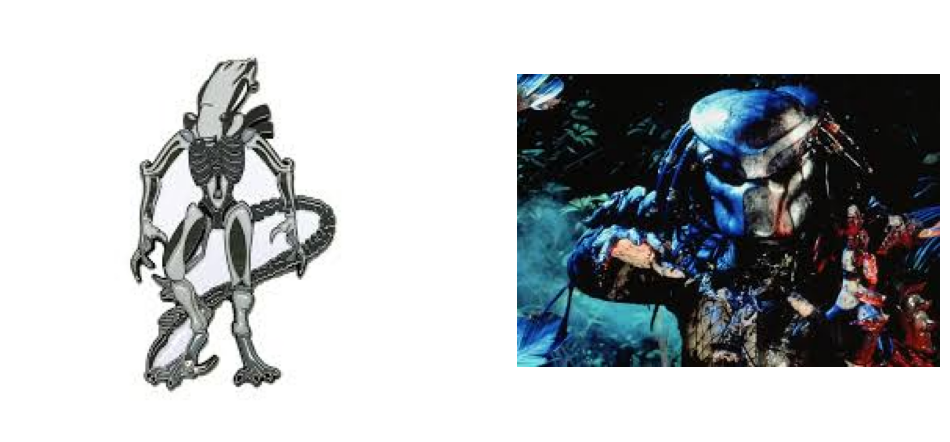

In [21]:
img1 = Image.open('/content/data/train/alien/0.jpg')
img2 = Image.open('/content/data/train/predator/0.jpg')

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(img1)
axes[0].axis('off')  # 축 눈금(테두리 및 좌표)을 제거
axes[1].imshow(img2)
axes[1].axis('off')
plt.show()

In [22]:
img1_input = data_transforms['validation'](img1)
img2_input = data_transforms['validation'](img2)
print(img1_input.shape)
print(img2_input.shape)

torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


In [23]:
test_batch = torch.stack([img1_input, img2_input])
# img1_input, img2_input은 torch.Tensor 형식이며, 보통 [C, H, W] 구조.
# 예: img1_input.shape = torch.Size([3, 224, 224])
# torch.stack([...]): 두 이미지를 하나의 배치(batch)로 합친다.
test_batch = test_batch.to(device)
test_batch.shape
# 2장(batch size = 2) 의 RGB 이미지로 구성된 4차원 텐서

# 딥러닝 모델은 배치 단위 입력을 기대하므로, 하나 이상의 이미지를 torch.stack()으로 묶는 것이 필수

torch.Size([2, 3, 224, 224])

In [24]:
y_pred = model(test_batch)
y_pred

tensor([[3.6411e-04],
        [1.0000e+00]], grad_fn=<SigmoidBackward0>)

(np.float64(-0.5), np.float64(269.5), np.float64(186.5), np.float64(-0.5))

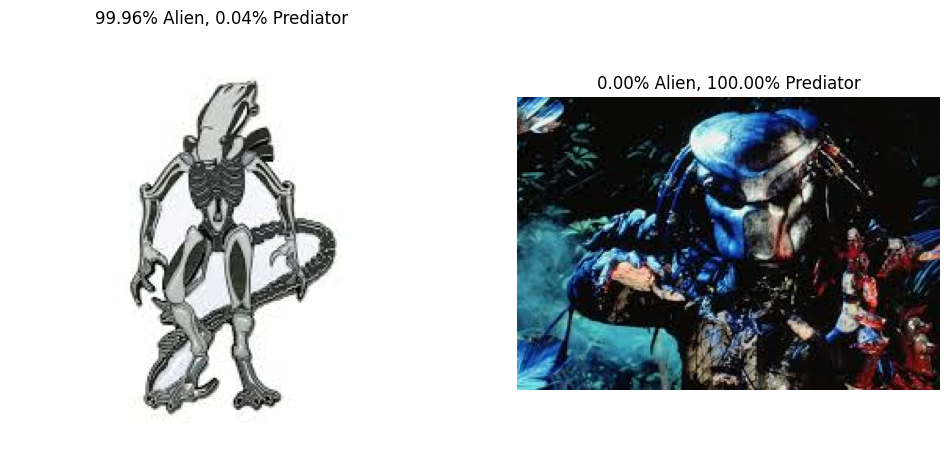

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].set_title(f'{(1-y_pred[0, 0])*100:.2f}% Alien, {(y_pred[0, 0])*100:.2f}% Prediator')
axes[0].imshow(img1)
axes[0].axis('off')

axes[1].set_title(f'{(1-y_pred[1, 0])*100:.2f}% Alien, {(y_pred[1, 0])*100:.2f}% Prediator')
axes[1].imshow(img2)
axes[1].axis('off')